In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL.Image as Image
import tensorflow_hub as hub
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [32]:
BATCH_SIZE = 64
IMG_SIZE = (180, 180)

train_dir = '../input/panerai-or-not/Panerai_or_Not/output/train'
validation_dir = '../input/panerai-or-not/Panerai_or_Not/output/val'
test_dir = '../input/panerai-or-not/Panerai_or_Not/output/val'


train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 12731 files belonging to 2 classes.
Found 1591 files belonging to 2 classes.
Found 1591 files belonging to 2 classes.


In [33]:
class_names = train_dataset.class_names
print(class_names)

['Not_Panerai', 'Panerai']


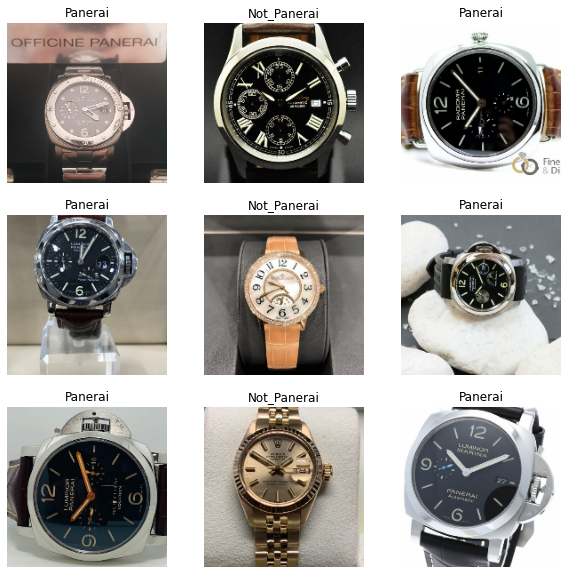

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [36]:
base_model = tf.keras.applications.InceptionV3(input_shape=(180,180,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [37]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 2048)


In [38]:
preprocess_input=preprocess_input

In [39]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)                                    
                                        ])

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [41]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [42]:
inputs = tf.keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs) # x
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [43]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
initial_epochs = 15

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
199/199 [==============================] - 77s 386ms/step - loss: 0.5985 - accuracy: 0.6661 - val_loss: 0.4230 - val_accuracy: 0.7574
Epoch 2/15
199/199 [==============================] - 77s 385ms/step - loss: 0.3836 - accuracy: 0.8027 - val_loss: 0.3058 - val_accuracy: 0.8523
Epoch 3/15
199/199 [==============================] - 66s 329ms/step - loss: 0.2949 - accuracy: 0.8663 - val_loss: 0.2473 - val_accuracy: 0.9302
Epoch 4/15
199/199 [==============================] - 75s 377ms/step - loss: 0.2431 - accuracy: 0.8977 - val_loss: 0.2124 - val_accuracy: 0.9283
Epoch 5/15
199/199 [==============================] - 65s 327ms/step - loss: 0.2119 - accuracy: 0.9179 - val_loss: 0.1860 - val_accuracy: 0.9491
Epoch 6/15
199/199 [==============================] - 54s 273ms/step - loss: 0.1709 - accuracy: 0.9434 - val_loss: 0.1500 - val_accuracy: 0.9692
Epoch 8/15
199/199 [==============================] - 58s 293ms/step - loss: 0.1532 - accuracy: 0.9528 - val_loss: 0.1380 - val_ac

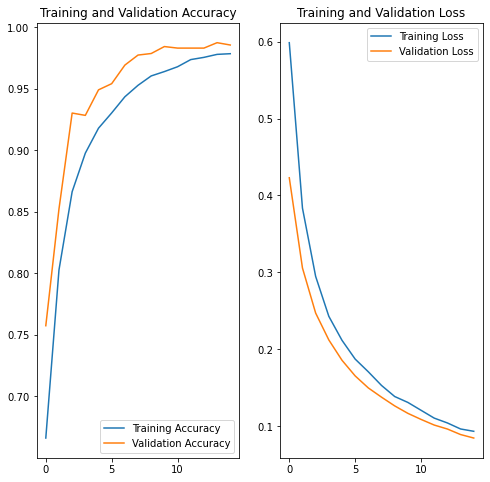

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1]
Labels:
 [0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1]


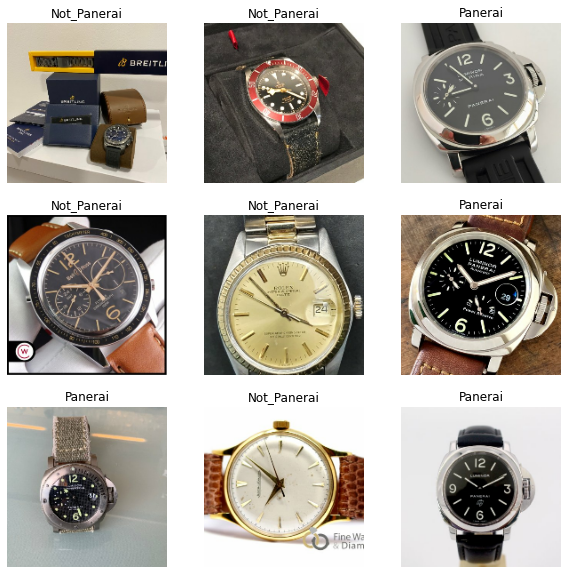

In [53]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [55]:
model.save('../models/model_Inception_pan_or_not.h5')